In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Configuration
DATA_DIR = '/kaggle/input/severstal-steel-defect-detection'
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_IMAGE_DIR = os.path.join(DATA_DIR, 'test_images')
MASK_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
# Load and inspect data
print("Loading CSV file...")
df = pd.read_csv(MASK_CSV_PATH)
print(f"Total entries: {len(df)}")

Loading CSV file...
Total entries: 7095


In [4]:

# Process labels
print("\nProcessing labels...")
image_class_df = df.groupby('ImageId')['ClassId'].apply(lambda x: list(set(x))).reset_index()
image_class_df['Labels'] = image_class_df['ClassId'].apply(
    lambda classes: [1 if (i+1) in classes else 0 for i in range(4)]
)


Processing labels...


In [5]:
# Load images and labels
print("\nLoading images and labels...")
images = []
labels = []

for _, row in tqdm(image_class_df.iterrows(), total=len(image_class_df)):
    img_id = row['ImageId']
    img_path = os.path.join(TRAIN_IMAGE_DIR, img_id)
    img = load_img(img_path, target_size=IMG_SIZE)
    images.append(img_to_array(img)/255.0)
    labels.append(row['Labels'])

X = np.array(images)
y = np.array(labels)
print(f"\nDataset shape - Images: {X.shape}, Labels: {y.shape}")


Loading images and labels...


100%|██████████| 6666/6666 [01:12<00:00, 91.68it/s] 



Dataset shape - Images: (6666, 224, 224, 3), Labels: (6666, 4)


In [6]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 5332, Validation samples: 1334


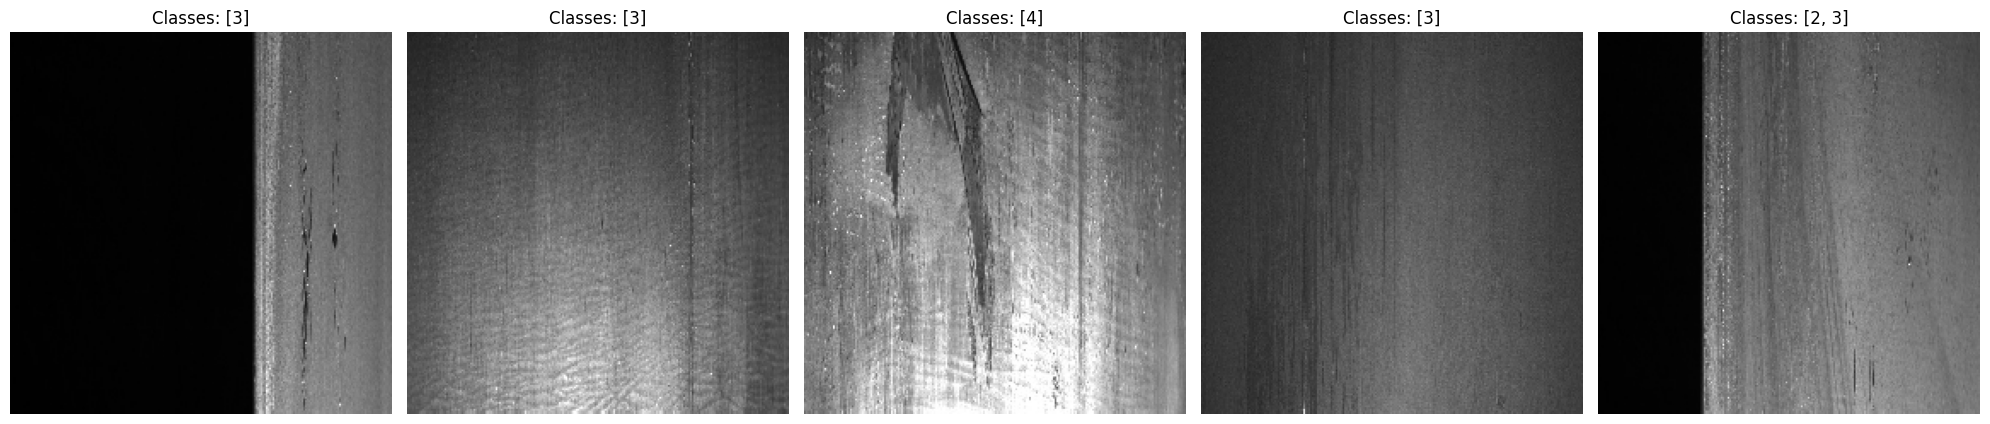

In [7]:
# Visualize samples
def plot_samples(images, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        class_labels = [j+1 for j, val in enumerate(labels[i]) if val == 1]
        plt.title(f"Classes: {class_labels}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(X_train[:5], y_train[:5])

In [8]:
# Detect multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

Number of GPUs: 1


In [9]:
with strategy.scope():
    # Input layer
    inputs = Input(shape=(224, 224, 3))

    # Convolutional layers
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(maxp_2)
    maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(maxp_3)
    maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(maxp_4)
    maxp_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)

    # Flatten layer
    flatten = Flatten()(maxp_5)

    # Fully connected layers with dropout for regularization
    dense = Dense(512, activation='relu')(flatten)
    dropout = Dropout(0.1)(dense)

    # Output layer
    output = Dense(4, activation='sigmoid')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [10]:
# Prepare datasets using tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
# Callbacks and compilation
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [12]:
# Train the model using the tf.data.Dataset objects
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7121 - loss: 0.4939 - precision: 0.7257 - recall: 0.6662 - val_accuracy: 0.7714 - val_loss: 0.3227 - val_precision: 0.7922 - val_recall: 0.7411 - learning_rate: 0.0010
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.7873 - loss: 0.3108 - precision: 0.8066 - recall: 0.7510 - val_accuracy: 0.7714 - val_loss: 0.3107 - val_precision: 0.8015 - val_recall: 0.7340 - learning_rate: 0.0010
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7840 - loss: 0.3031 - precision: 0.8098 - recall: 0.7442 - val_accuracy: 0.7781 - val_loss: 0.2781 - val_precision: 0.7994 - val_recall: 0.7495 - learning_rate: 0.0010
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7952 - loss: 0.2760 - precision: 0.8105 - recall: 0.7640 - val_accuracy: 0.7736 - val_loss: 0.2725 - val_precision: 0.7972 - val_recall: 0.7474 - learning_rate: 0.0010
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - 

In [13]:
# Save final model
model.save('defect_classifier.keras')

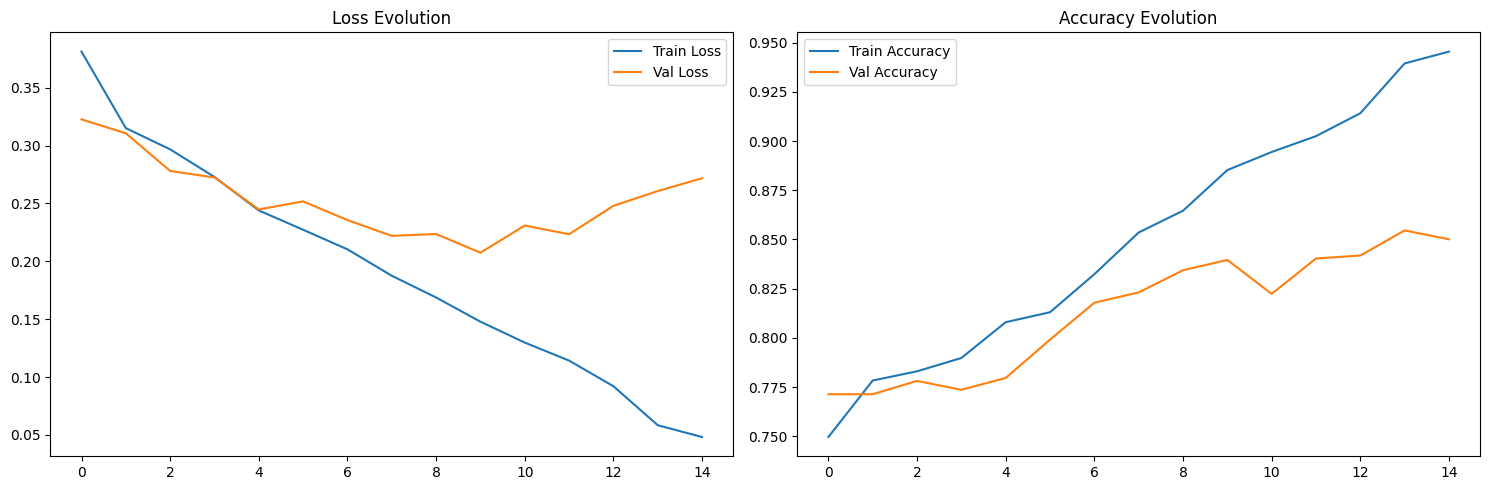

In [14]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Evolution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("results.png")
    plt.show()

plot_history(history)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Overall Classification Report:
              precision    recall  f1-score   support

     Class 1       0.83      0.67      0.74       194
     Class 2       0.58      0.58      0.58        33
     Class 3       0.90      0.92      0.91      1025
     Class 4       0.71      0.53      0.61       173

   micro avg       0.86      0.83      0.84      1425
   macro avg       0.75      0.67      0.71      1425
weighted avg       0.86      0.83      0.84      1425
 samples avg       0.85      0.84      0.84      1425



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


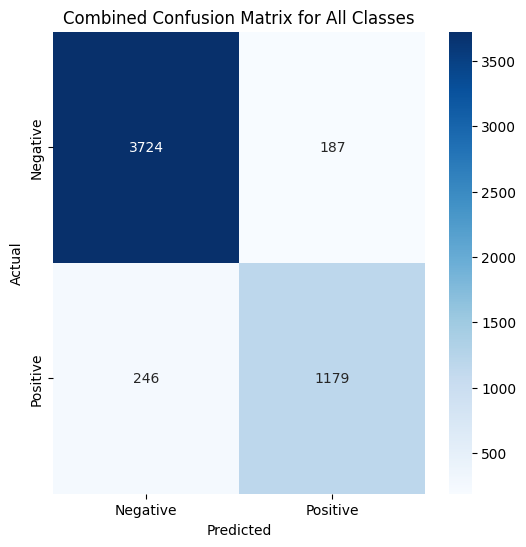

In [15]:
def evaluate_model_combined(X, y, batch_size=32):
    # Get predictions and convert them to binary values
    y_pred = model.predict(X, batch_size=batch_size)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Print the overall classification report
    print("Overall Classification Report:")
    print(classification_report(y, y_pred, target_names=[f'Class {i+1}' for i in range(4)]))
    
    # Flatten the arrays to combine all classes into a single confusion matrix
    y_true_flat = y.flatten()
    y_pred_flat = y_pred.flatten()
    
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.title('Combined Confusion Matrix for All Classes')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("Confusion_Matrix.png")
    plt.show()

# Call the function to evaluate the model with a single confusion matrix for all classes
evaluate_model_combined(X_val, y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


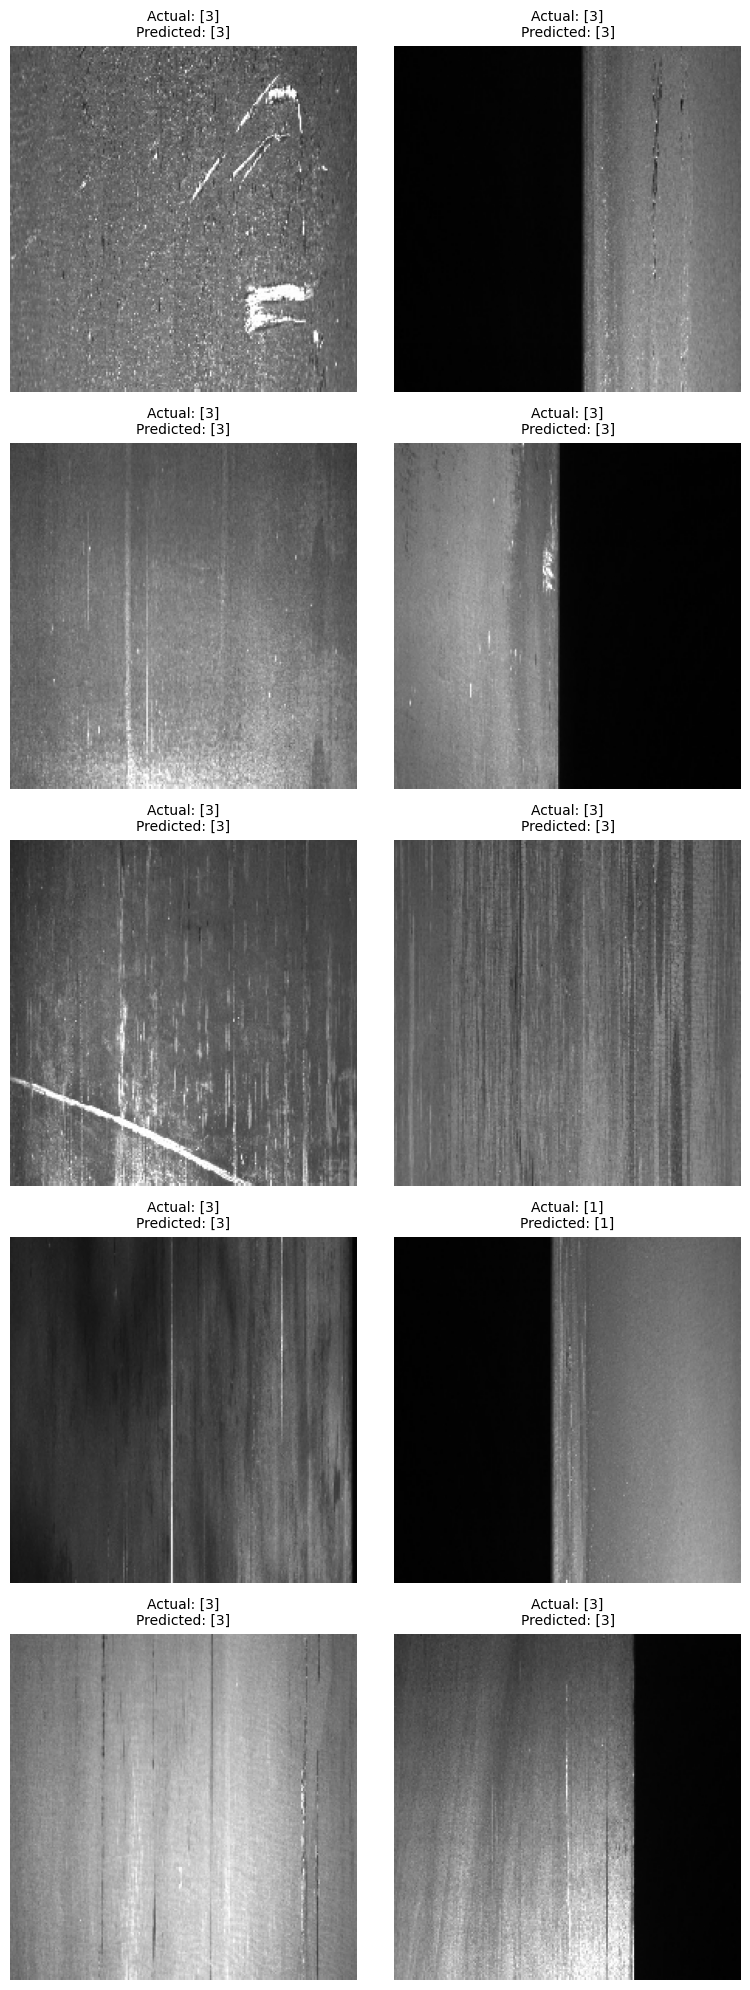

In [16]:
# Prediction visualization
def plot_predictions(samples=20, grid_shape=(5, 2)):
    indices = np.random.choice(len(X_val), samples, replace=False)
    test_images = X_val[indices]
    test_labels = y_val[indices]
    
    preds = model.predict(test_images)
    preds = (preds > 0.5).astype(int)

    rows, cols = grid_shape
    plt.figure(figsize=(cols * 4, rows * 4))  # Adjust figure size based on grid

    for i in range(samples):
        plt.subplot(rows, cols, i+1)
        plt.imshow(test_images[i])
        actual = [j+1 for j, val in enumerate(test_labels[i]) if val == 1]
        predicted = [j+1 for j, val in enumerate(preds[i]) if val == 1]
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("predictions.png")  # Save the grid image
    plt.show()

plot_predictions(samples=10, grid_shape=(5, 2))